7 3
 count =  6554
 dis =  1.0836353298131
 count =  174
 dis =  1.083635329812889
 count =  213
 dis =  1.2546410375497172
 count =  235
 dis =  1.4080373004747322
 count =  241
 dis =  1.567231604283031
 count =  240
 dis =  1.7729817070006346
 count =  245
 dis =  2.033621174283835
 count =  246
 dis =  2.370380500703724
 count =  249
 dis =  2.8084027100124382
 count =  250
 dis =  3.3937255100748978
 count =  255
 dis =  4.187236272104829
 count =  256
 dis =  5.270666885355916
 count =  258
 dis =  6.759737107551066
 count =  263
 dis =  8.818714394448389
 count =  268
 dis =  11.68130108790409
bottleneck_nodes =  ['p0', 'p7', 'p8', 'p9', 'p14']
path_nodes =  ['656' '880' '520' '1192' '280' '312' '1668' '1092' '612' '684' '738'
 '1242' '486' '1535' '1319'] ['p0', 'p7', 'p8', 'p9', 'p14']


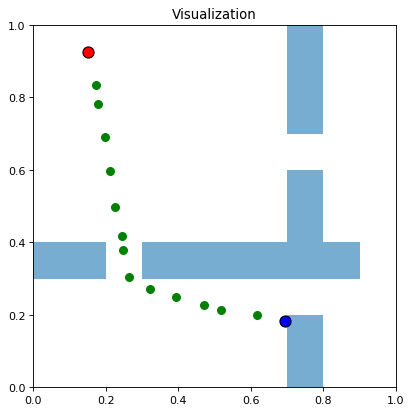

path_nodes =  ['656' '880' '520' '1192' '280' '312' '1668' '1092' '612' '684' '738'
 '1242' '486' '1535' '1319'] ['p0', 'p7', 'p8', 'p9', 'p14']


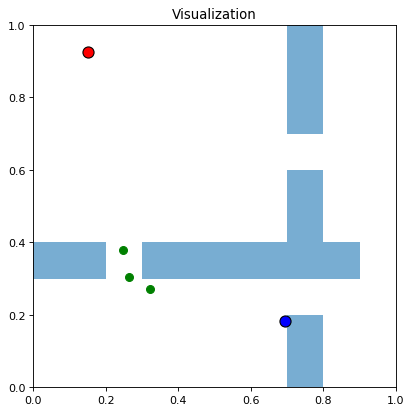

In [3]:
import numpy as np
import networkx as nx
from itertools import chain
import helper
import astar
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_nodes(curr_occ_grid, curr_node_posns, start_pos, goal_pos):
    fig1 = plt.figure(figsize=(10,6), dpi=80)
    ax1 = fig1.add_subplot(111, aspect='equal')

    occ_g = curr_occ_grid.reshape(10,10)
    for i in range(10):
            for j in range(10):
                if(occ_g[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/10.0, j/10.0),   # (x,y)
                    0.1,          # width
                    0.1,          # height
                    alpha=0.6
                    ))
    plt.scatter(start_pos[0], start_pos[1], color="red", s=100, edgecolors='black', alpha=1, zorder=10) # init
    plt.scatter(goal_pos[0], goal_pos[1], color="blue", s=100, edgecolors='black', alpha=1, zorder=10) # goal

    curr_node_posns = np.array(curr_node_posns)
    if len(curr_node_posns)>0:
        plt.scatter(curr_node_posns[:,0], curr_node_posns[:,1], s = 50, color = 'green')
    plt.title("Visualization")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()

def get_bottleneck_nodes(dense_G, sparse_G, path_nodes, occ_grid, dis, row, col, inc):
    assert len(path_nodes)>0
    THRESH = 0.1
    P_EPS = 10
    new_edges = []
    start_n = 'p0'
    goal_n = 'p'+str(len(path_nodes)-1)
    for count in range(len(path_nodes)):
        s1 = dense_G.nodes[path_nodes[count]]['state']
        sparse_G.add_node('p'+str(count), state = s1)
        if count>0:
            n1 = 'p'+str(count-1)
            n2 = 'p'+str(count)
            sparse_G.add_edge(n1, n2)
            sparse_G[n1][n2]['weight'] = helper.calc_weight_states(sparse_G.nodes[n1]['state'], sparse_G.nodes[n2]['state'])
            new_edges.append((n1, n2))
        for node in sparse_G.nodes():
            s2 = sparse_G.nodes[node]['state']
            if 'p' in s2:
                continue

            if helper.calc_weight_states(s1, s2) < THRESH:
                n1 = node
                n2 = 'p'+str(count)
                sparse_G.add_edge(node, 'p'+str(count))
                sparse_G[n1][n2]['weight'] = helper.calc_weight_states(sparse_G.nodes[n1]['state'], sparse_G.nodes[n2]['state'])
                new_edges.append((node, 'p'+str(count)))

    curr_path_nodes, curr_dis = astar.astar(sparse_G, start_n, goal_n, occ_grid, row, col, inc)
    while curr_dis < P_EPS*dis:
        for edge in new_edges:
            sparse_G[edge[0]][edge[1]]['weight'] *= 1.2
        curr_path_nodes, curr_dis = astar.astar(sparse_G, start_n, goal_n, occ_grid, row, col, inc)

    common_nodes = []
    for n in curr_path_nodes:
        if 'p' in n:
            common_nodes.append(n)

    return common_nodes, curr_path_nodes

def main():
    INC = 0.03
    dense_G = nx.read_graphml("graphs/dense_graph.graphml")
    sparse_G = nx.read_graphml("graphs/shallow_graph.graphml")

    occ_grid, row, col = helper.get_random_occ_grid()
    print(row, col)
    start_n, goal_n = helper.get_valid_start_goal(dense_G, occ_grid, row, col, inc = INC)
    start_pos = helper.state_to_numpy(dense_G.nodes[start_n]['state'])
    goal_pos = helper.state_to_numpy(dense_G.nodes[goal_n]['state'])

    path_nodes, dis = astar.astar(dense_G, start_n, goal_n, occ_grid, row, col, inc = INC)
    bottleneck_nodes, curr_path_nodes = get_bottleneck_nodes(dense_G, sparse_G, path_nodes, occ_grid, dis, row, col, inc = INC)
    print("bottleneck_nodes = ", bottleneck_nodes)
    points_x = []
    points_y = []
    print("path_nodes = ", path_nodes, bottleneck_nodes)
    for node in path_nodes:
        s = helper.state_to_numpy(dense_G.nodes[node]['state'])
        points_x.append(s[0])
        points_y.append(s[1])

    visualize_nodes(occ_grid,np.array(list(zip(points_x,points_y))), start_pos, goal_pos)

    points_x = []
    points_y = []
    print("path_nodes = ", path_nodes, bottleneck_nodes)
    for node in bottleneck_nodes:
        s = helper.state_to_numpy(sparse_G.nodes[node]['state'])
        points_x.append(s[0])
        points_y.append(s[1])

    visualize_nodes(occ_grid,np.array(list(zip(points_x,points_y))), start_pos, goal_pos)
if __name__ == '__main__':
    main()

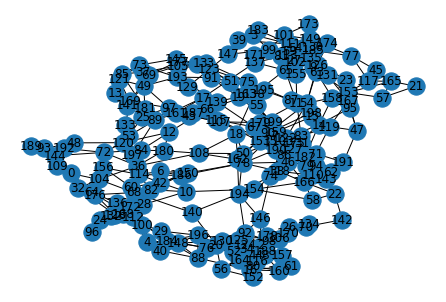

In [7]:
sparse_G = nx.read_graphml("graphs/shallow_graph.graphml")
nx.draw(sparse_G, with_labels = True)
plt.draw()
plt.show()